In [1]:
from my_functions import *

#Main Libraries 
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import datetime
import scipy.fftpack
import tensorflow as tf
from tensorflow import keras # And the tf and keras framework, thanks to Google
from tensorflow.python.framework import ops
import scipy.io as io
import sys, os, time
import math
from scipy.fft import fft, fftfreq #Fourier
import pywt # Wavelet
from tqdm import tqdm # for print progress <---------------------------------------------------
import cv2 # computer vision problems library

from skimage.restoration import denoise_wavelet #Noise
import matplotlib.patheffects as PathEffects
import seaborn as sns
from sklearn.manifold import TSNE
import time
from IPython.display import Audio # <---- play audio

#Extra Libraries 
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib import cm
from scipy.spatial.distance import pdist, squareform
import random
import pandas as pd # data processing, CSV file I/O 
import seaborn as sns #I used sns.distplot because it has more manual properties than plt.hist()
from scipy.stats import pearsonr #includes the PCC function

#--------------------------------------------------------------------- Saved Compressed Sub Wavelet Data
compress_sub_img_o_1 = "Wavelet_Data/comp_sub_o_1.mat"
compress_sub_img_o_2 = "Wavelet_Data/comp_sub_o_2.mat"
compress_sub_img_o_3 = "Wavelet_Data/comp_sub_o_3.mat"
compress_sub_img_o_4 = "Wavelet_Data/comp_sub_o_4.mat"
compress_sub_img_o_5 = "Wavelet_Data/comp_sub_o_5.mat"
compress_sub_img_o_6 = "Wavelet_Data/comp_sub_o_6.mat"
compress_sub_img_o_7 = "Wavelet_Data/comp_sub_o_7.mat"
compress_sub_img_o_8 = "Wavelet_Data/comp_sub_o_8.mat"
#------------------------------
compress_sub_img_c_1 = "Wavelet_Data/comp_sub_c_1.mat"
compress_sub_img_c_2 = "Wavelet_Data/comp_sub_c_2.mat"
compress_sub_img_c_3 = "Wavelet_Data/comp_sub_c_3.mat"
compress_sub_img_c_4 = "Wavelet_Data/comp_sub_c_4.mat"
compress_sub_img_c_5 = "Wavelet_Data/comp_sub_c_5.mat"

#--------------------------------------------------------------------- Path to Save Wavelet_Frequences Data
frequences_o_1 = "Wavelet_Data/frequences_o_1.mat" 
frequences_o_2 = "Wavelet_Data/frequences_o_2.mat"
frequences_o_3 = "Wavelet_Data/frequences_o_3.mat" 
frequences_o_4 = "Wavelet_Data/frequences_o_4.mat"
frequences_o_5 = "Wavelet_Data/frequences_o_5.mat"
frequences_o_6 = "Wavelet_Data/frequences_o_6.mat" 
frequences_o_7 = "Wavelet_Data/frequences_o_7.mat"
frequences_o_8 = "Wavelet_Data/frequences_o_8.mat"  
#------------------------------
frequences_c_1 = "Wavelet_Data/frequences_c_1.mat" 
frequences_c_2 = "Wavelet_Data/frequences_c_2.mat"  
frequences_c_3 = "Wavelet_Data/frequences_c_3.mat"
frequences_c_4 = "Wavelet_Data/frequences_c_4.mat"
frequences_c_5 = "Wavelet_Data/frequences_c_5.mat"

In [2]:
wavelet_path = compress_sub_img_c_1
freqs_path = frequences_c_1

#---------------------------- Load Wavelet data
wavelet_trackdata = io.loadmat(wavelet_path)
wavelet_data = wavelet_trackdata['saved_data'];
print("Number of Bursts in Dataset:",wavelet_data.shape[0])
print("Number of Wavelets/Spikes per Burst:",wavelet_data.shape[1])
print("Total Number of Wavelets in Dataset:",wavelet_data.shape[0]*wavelet_data.shape[1])
print("Wavelet 2D-Image with shape:",wavelet_data.shape[2:])     
#---------------------------- Load Frequency data
freqs_trackdata = io.loadmat(freqs_path)
freqs_data = freqs_trackdata['saved_data'];
freqs_data = freqs_data[0]
print("Frequences shape:",freqs_data.shape)

Number of Bursts in Dataset: 106
Number of Wavelets/Spikes per Burst: 13
Total Number of Wavelets in Dataset: 1378
Wavelet 2D-Image with shape: (80, 200)
Frequences shape: (80,)


Alpha Shape:https://en.wikipedia.org/wiki/Alpha_shape

In [3]:
#---------------------------- A simple 2D-Array/Image Plot
def Plot_CWT_Small(array,min_color, max_color):
    plt.figure(1, figsize=(7,3))
    plt.imshow(array, cmap='seismic', aspect='auto',vmin=min_color, vmax=max_color)
    plt.colorbar()
    plt.show()
    
#---------------------------- This function takes a 2D-Array Image and the values that are lower than threshold it makes them Zero
def Keep_Values_Higher_Than_Threshold(arr,threshold):
    curr_arr = np.float32(np.array([row[:] for row in arr]))
    for i in range(0,curr_arr.shape[0]):
        for j in range(0,curr_arr.shape[1]):
            if(curr_arr[i,j]<threshold):
                curr_arr[i,j] = 0
    return(curr_arr)

#---------------------------- This function takes a 2D-Array and returns the same array but in a form of plane 2D -->(2,n)
def Transform_Image_to_Points(img):
    img_points = []
    def column_extract(matrix, matrix_index):
        return [row[matrix_index] for row in matrix]
    for j in range(0,img.shape[1]):
        curr_column = column_extract(img, j)
        for i in range(0,len(curr_column)):
            if(curr_column[i]>0):
                img_points.append([j,i])
    img_points = np.array(img_points) 
    return(img_points)

#---------------------------- Compute the alpha shape (concave hull) of a set of (n,2) points.
from scipy.spatial import Delaunay
def alpha_shape(points, alpha, only_outer=True): # param only_outer: boolean value to specify if we keep only the outer border or also inner edges. 
    #return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are the indices in the points array.                
    def add_edge(edges, i, j): # Add a line between the i-th and j-th points, if not in the list already
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer: # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    for ia, ib, ic in tri.simplices: # Loop over triangles: ia, ib, ic = indices of corner points of the triangle
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle --> www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

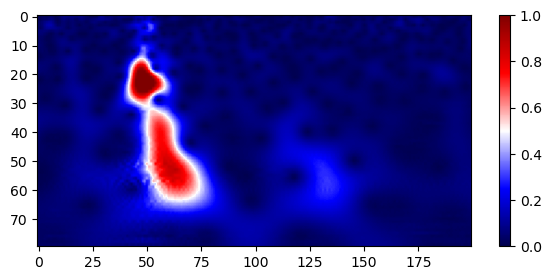

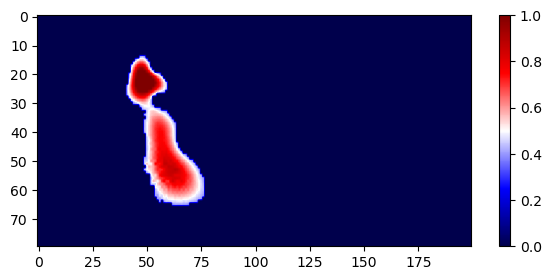

(841, 2)


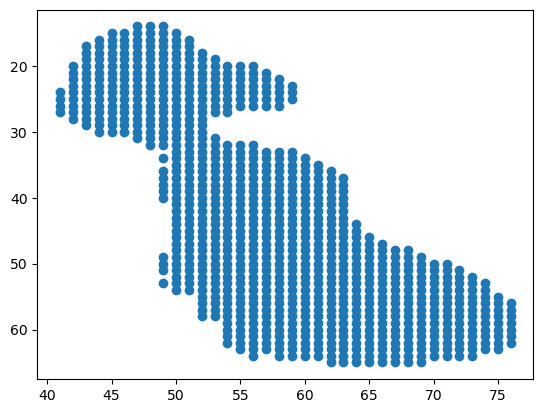

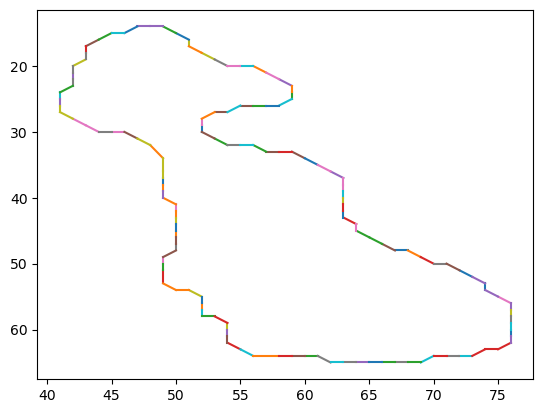

In [4]:
Plot_CWT_Small(wavelet_data[22,1],0,1)

img_with_threshold = Keep_Values_Higher_Than_Threshold(wavelet_data[22,1],0.4)
Plot_CWT_Small(img_with_threshold,0,1)

img_transform = Transform_Image_to_Points(img_with_threshold)
print(img_transform.shape)
plt.plot(img_transform[:,0],img_transform[:,1],'o')
plt.gca().invert_yaxis()
plt.show()

edges = alpha_shape(img_transform, alpha=1.25, only_outer=True) # Computing the alpha shape
plt.figure() # Plotting the output
for i, j in edges:
    plt.plot(img_transform[[i, j], 0], img_transform[[i, j], 1])
plt.gca().invert_yaxis()
plt.show()

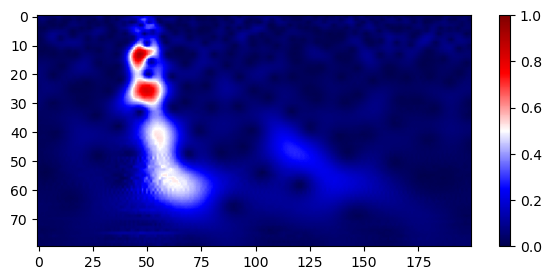

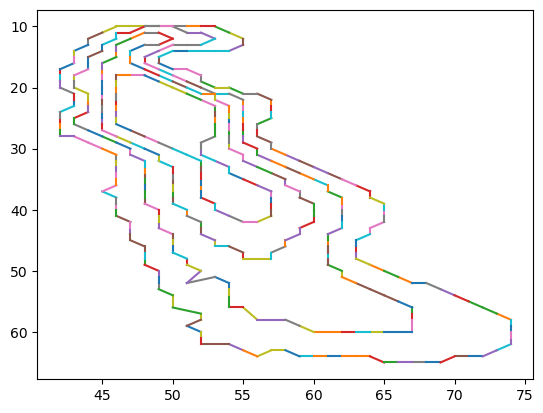

In [5]:
Plot_CWT_Small(wavelet_data[22,3],0,1)

plt.figure() # Plotting the output
thresholds_list = [0.4,0.6,0.8,0.98]
for threshold_item in thresholds_list:
    img_with_threshold = Keep_Values_Higher_Than_Threshold(wavelet_data[22,2],threshold_item)
    img_transform = Transform_Image_to_Points(img_with_threshold)

    edges = alpha_shape(img_transform, alpha=1.25, only_outer=True) # Computing the alpha shape 
    for i, j in edges:
        plt.plot(img_transform[[i, j], 0], img_transform[[i, j], 1])
plt.gca().invert_yaxis()
plt.show()

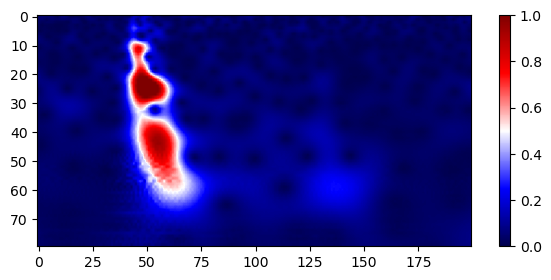

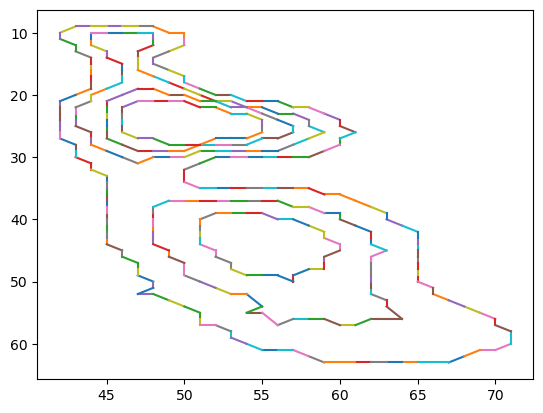

In [49]:
Plot_CWT_Small(wavelet_data[24,2],0,1)

wavelet_img = wavelet_data[24,2]
wavelet_img_lines = np.zeros((wavelet_img.shape[0],wavelet_img.shape[1]))
wavelet_edges_nodes = []

plt.figure() # Plotting the output
thresholds_list = [0.4,0.6,0.8,0.98]
for threshold_item in thresholds_list:
    img_with_threshold = Keep_Values_Higher_Than_Threshold(wavelet_data[24,2],threshold_item)
    img_transform = Transform_Image_to_Points(img_with_threshold)

    edges = alpha_shape(img_transform, alpha=1.25, only_outer=True) # Computing the alpha shape 
    for i, j in edges:
        point_a = np.array(img_transform[[i, j],0])
        point_b = np.array(img_transform[[i, j],1])
        point_a_final = np.array([point_a[0],point_b[0]])
        point_b_final = np.array([point_a[1],point_b[1]])
        wavelet_img_lines[point_a_final[0],point_a_final[1]] = 1
        wavelet_img_lines[point_b_final[0],point_b_final[1]] = 1
        wavelet_edges_nodes.append(point_a_final)
        wavelet_edges_nodes.append(point_b_final)
        plt.plot(img_transform[[i, j], 0], img_transform[[i, j], 1])
wavelet_img_lines = np.array(wavelet_img_lines)
plt.gca().invert_yaxis()
plt.savefig('aaaa.jpg')
plt.show()


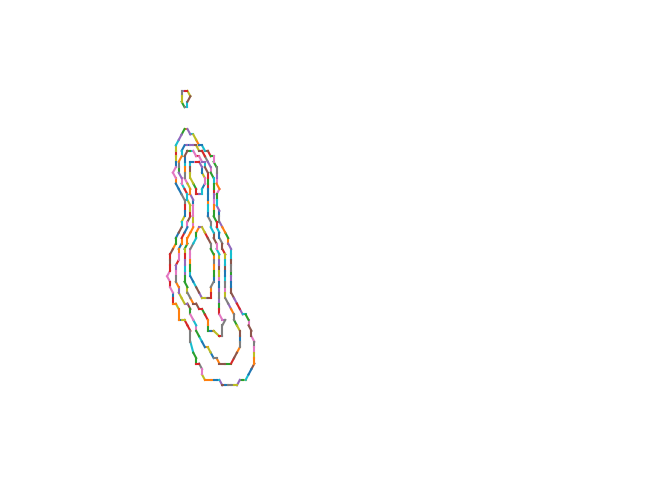

In [34]:
fig = plt.figure(frameon=False) # Plotting the output
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
thresholds_list = [0.4,0.6,0.8,0.98]
for threshold_item in thresholds_list:
    img_with_threshold = Keep_Values_Higher_Than_Threshold(wavelet_data[24,1],threshold_item)
    img_transform = Transform_Image_to_Points(img_with_threshold)

    edges = alpha_shape(img_transform, alpha=1.25, only_outer=True) # Computing the alpha shape 
    for i, j in edges:
        ax.plot(img_transform[[i, j], 0], img_transform[[i, j], 1])
plt.gca().invert_yaxis()
plt.plot(0,0)
plt.plot(200,80)
fig.savefig('aaa1.jpg')
plt.show()

Shape original RGB: (480, 640, 3)
Shape Grey: (480, 640)
Type: uint8


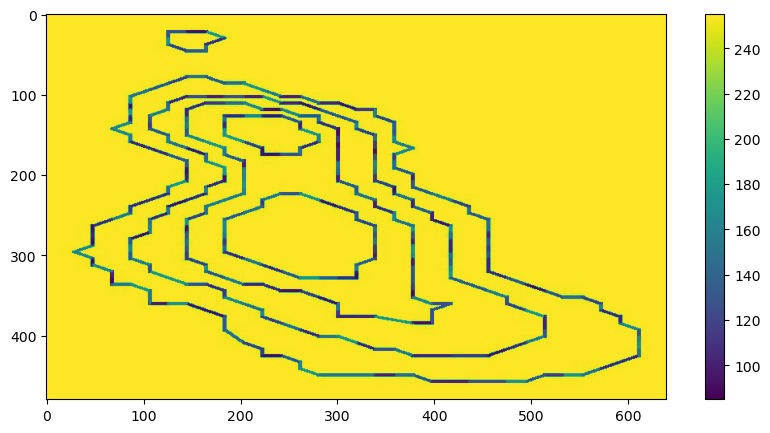

In [8]:
img = cv2.imread('aaa.jpg')
print("Shape original RGB:",img.shape)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Shape Grey:",gray_img.shape)
print("Type:",gray_img.dtype)

plt.figure(1, figsize=(10,5))
plt.imshow(gray_img, aspect='auto')
plt.colorbar()
plt.show() 